In [97]:
import os
import scanpy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sys
import pandas as pd
import numpy as np
import scvi
scvi.settings.seed = 0
from sklearn.neighbors import KNeighborsClassifier

sys.path.append('..')
from custom_functions import *

import warnings
warnings.filterwarnings("ignore")

save_format = "svg" 

Seed set to 0


In [34]:
dataset='gastruloid'

In [35]:
data_folder = "data/gastruloid"
analysis_name='gastruloid_prisca'

if not os.path.isdir(f"results/{analysis_name}"):
    os.makedirs(f"results/{analysis_name}", exist_ok=True)
if not os.path.isdir(f"results/{analysis_name}/umap_genes"):
    os.makedirs(f"results/{analysis_name}/umap_genes", exist_ok=True)

# 0. Construct AnnData

In [ ]:
construct_anndata=False

In [38]:
if construct_anndata:    
    # load mtx
    adata=sp.read_mtx(f'{data_folder}/GSE229513_UMI_counts.mtx.gz').T
    # load genes
    genes=pd.read_csv(f'{data_folder}/GSE229513_genes.tsv.gz', index_col=0)
    adata.var=genes
    # load genes
    cells=pd.read_csv(f'{data_folder}/GSE229513_barcodes.tsv.gz', index_col=0,header=None)
    cells.index.name='barcode'
    cells['cell'] = 'cell_' + pd.Series(np.arange(adata.shape[0]),index=cells.index).astype(str)
    cells['sample'] = pd.Series([x.split(':')[0].replace(' ','-') for x in cells.index.values], index=cells.index)
    cells['stage'] = pd.Series([x.split('-')[1].split('h')[0] for x in cells['sample'].values], index=cells.index) + 'h'
    adata.obs=cells
    adata.layers['counts'] = adata.X.copy()
        

## Save Anndata file

In [39]:
if construct_anndata:
    adata.write(f'{data_folder}/{analysis_name}_raw.h5ad')

# Analysis

- Parameters

In [ ]:
parameters={'target_sum':10000,
            'metric': 'correlation',
            'n_top_genes':2000,
            'n_pcs':30,
            'pca_random_factor':3,
            'resolution':0.5,
            }
parameters

{'target_sum': 10000,
 'metric': 'correlation',
 'n_top_genes': 2000,
 'n_pcs': 30,
 'pca_random_factor': 3}

## Load adata

In [41]:
adata = sp.read_h5ad(f'{data_folder}/{analysis_name}_raw.h5ad')

# 1. QC
Each sample undergoes QC individually that checks on:
- % mitochondrial genes **< 10%**
- Min/Max thresholds of total counts
- Min/Max threshold of total genes

Then, adata is **filtered** accordingly

*Tresholds per batch of cells is computed automatedly by **qc_threshold** custom function*

In [42]:
adatas=[]

for batch in adata.obs['sample'].unique():
    print(f'Performing QC to {batch}')

    ad = adata[adata.obs['sample']==batch]
    ad.layers["counts"] = ad.X.copy() #save raw counts layer
    ad.var_names_make_unique()

    # % mito
    mt_max = 10 # Mt max threshold: 10%
    ad.var["mt"] = ad.var_names.str.startswith("Mt")
    sp.pp.calculate_qc_metrics(ad, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # min/max total and genes counts
    tc_min, tc_max= qc_threshold(ad.obs['total_counts'].values)
    g_min, g_max= qc_threshold(ad.obs['n_genes_by_counts'].values)

    # Plot QC metrics
    g = sns.JointGrid(data=ad.obs, x='total_counts', y='n_genes_by_counts', height=6)

    g.plot_marginals(sns.histplot, bins=30)

    sns.scatterplot(data=ad.obs, x='total_counts', y='n_genes_by_counts', 
                    hue='pct_counts_mt', ax=g.ax_joint)

    g.ax_joint.axvline(x=tc_min, color='red', linestyle='--', linewidth=1)
    g.ax_joint.axvline(x=tc_max, color='red', linestyle='--', linewidth=1)

    g.ax_joint.axhline(y=g_min, color='red', linestyle='--', linewidth=1)
    g.ax_joint.axhline(y=g_max, color='red', linestyle='--', linewidth=1)

    # save plot
    g.savefig(f"results/{analysis_name}/{batch}_qc_counts.{save_format}")   
    plt.close()

    ### adata filtering ###
    ad = ad[ad.obs["total_counts"] >= tc_min,:]
    ad = ad[ad.obs["total_counts"] <= tc_max,:]

    ad = ad[ad.obs["n_genes_by_counts"] >= g_min,:]
    ad = ad[ad.obs["n_genes_by_counts"] <= g_max,:]

    ad = ad[ad.obs["pct_counts_mt"] <= mt_max,:]

    # append processed adata
    adatas.append(ad)

adata=sp.concat(adatas, join='outer')
adata.obs.reset_index(drop=True, inplace=True)

Performing QC to S1-0h
Performing QC to S2-48h
Performing QC to S3-52h
Performing QC to S4-56h
Performing QC to S6-96h
Performing QC to S7.1-108h
Performing QC to S7.2-108h
Performing QC to S8.2-120h
Performing QC to SBR-24h
Performing QC to SBR-36h
Performing QC to SBR-48h
Performing QC to SBR-60h
Performing QC to SBR-72h
Performing QC to SBR-84h_A
Performing QC to SBR-84h_B


# 2. DR

## Preprocessing

In [43]:
sp.pp.normalize_total(adata,target_sum=parameters['target_sum'])
sp.pp.log1p(adata)

### HVG

In [44]:
sp.pp.highly_variable_genes(adata)

In [45]:
genes = pd.read_csv("cell_cycle_genes.txt",header=None).iloc[:,0].str.capitalize().values
for i in genes:
    if i in adata.var.index.values:
        adata.var.loc[i,"highly_variable"] = False

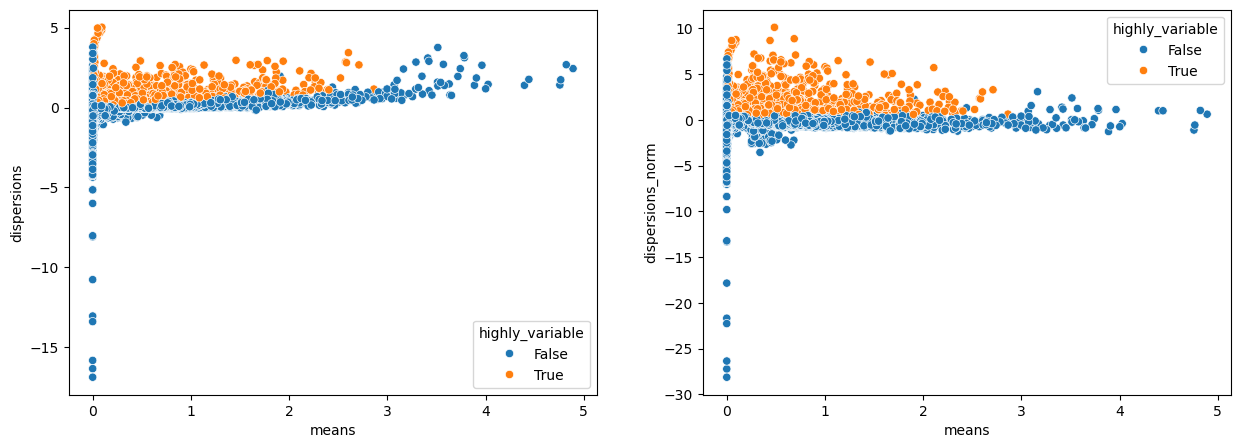

In [98]:
fig,ax = plt.subplots(1,2,figsize=[15,5])
sns.scatterplot(data = adata.var, x="means", y="dispersions", hue="highly_variable", ax=ax[0])
sns.scatterplot(data = adata.var, x="means", y="dispersions_norm", hue="highly_variable", ax=ax[1])
fig.savefig(f"results/{analysis_name}/dr_hvgs.{save_format}")        

### PCA

In [47]:
sp.pp.pca(adata,use_highly_variable=True)    

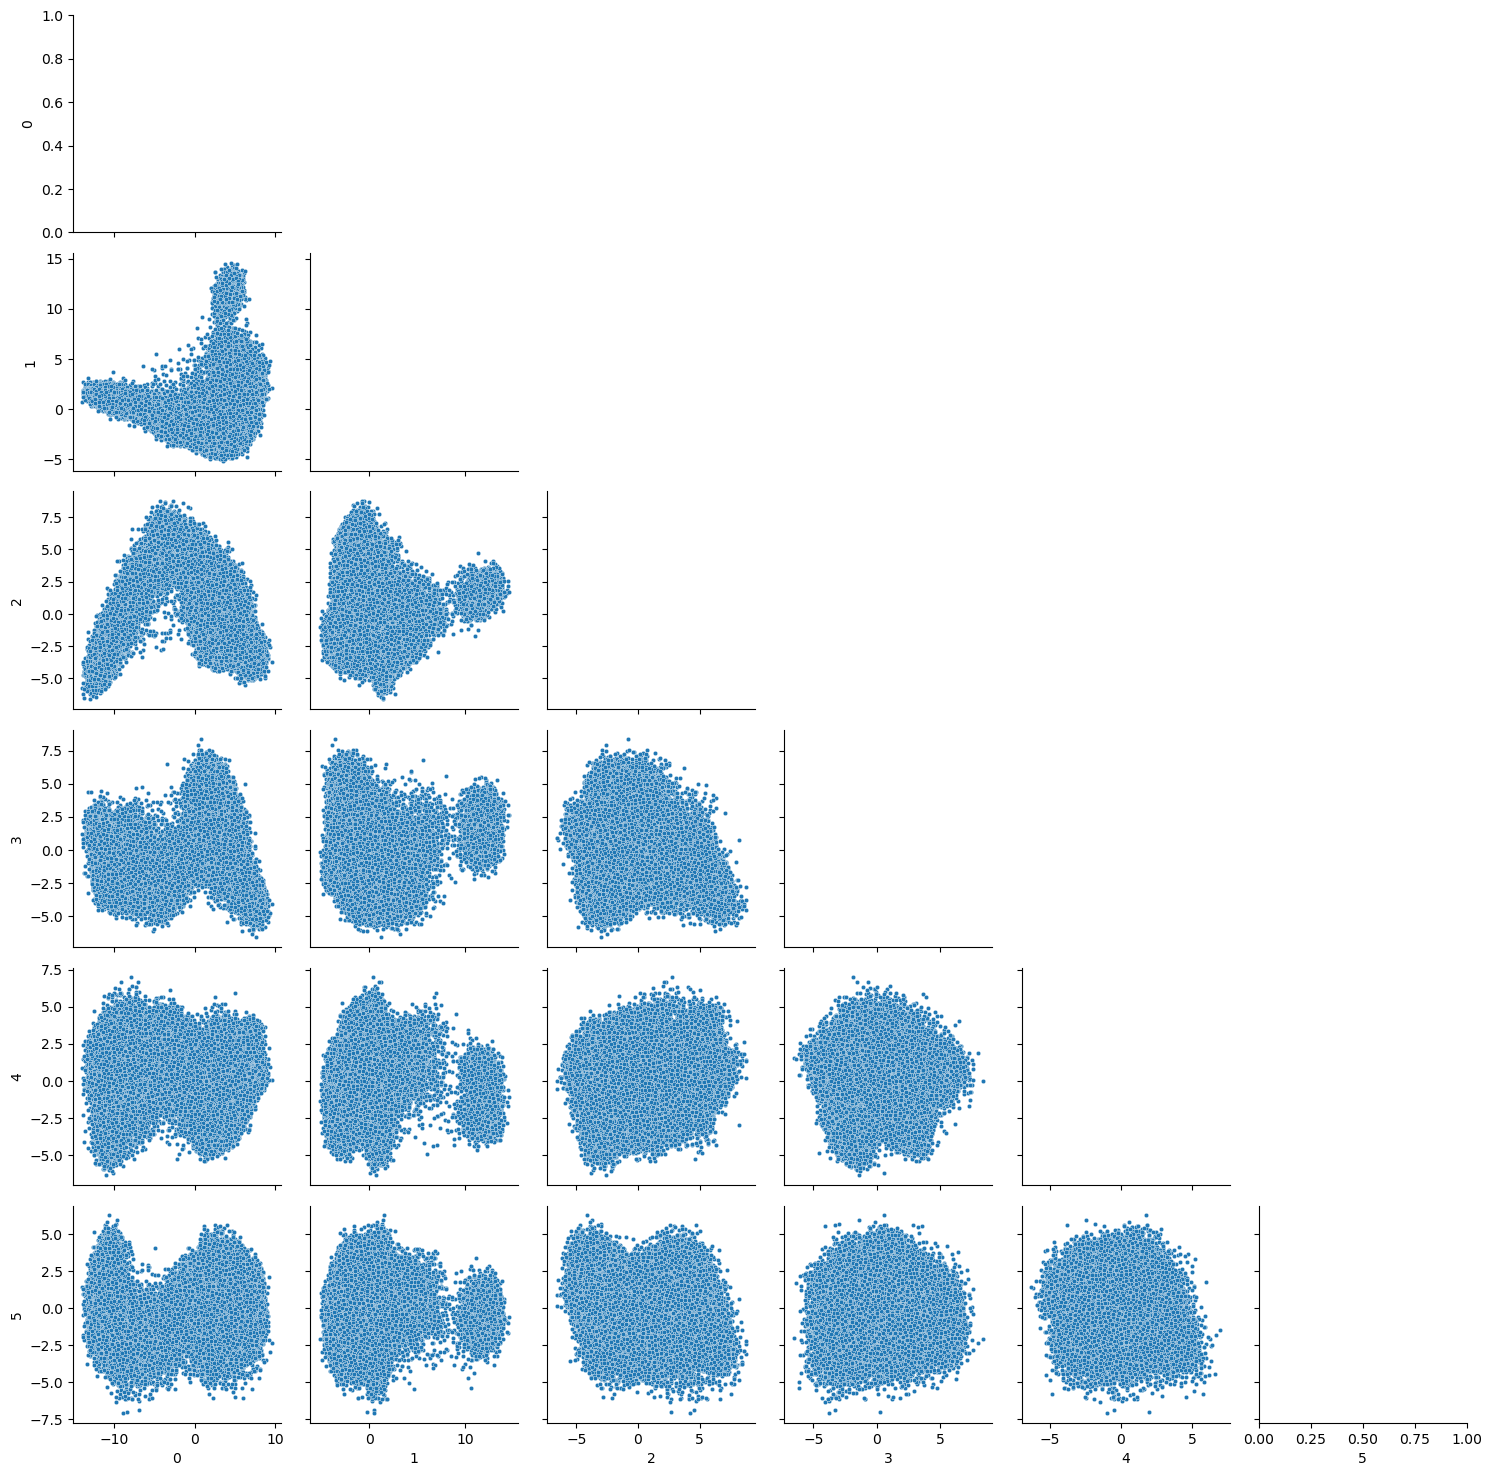

In [99]:
fig = sns.PairGrid(pd.DataFrame(adata.obsm["X_pca"][:,:6]), diag_sharey=False, corner=True)
fig.map_lower(sns.scatterplot,s=10)
fig.savefig(f"results/{analysis_name}/dr_pcs.{save_format}")      

### UMAP representation

In [49]:
parameters['n_pcs']=int(parameters['n_pcs'])

In [50]:
sp.pp.neighbors(adata, 
                metric=parameters["metric"], 
                n_pcs=parameters['n_pcs'],
                use_rep="X_pca",
                key_added="neighbors_pca",
                n_neighbors=10,
)
sp.tl.umap(adata, neighbors_key="neighbors_pca")
adata.obsm["X_umap_pca"] = adata.obsm["X_umap"].copy()

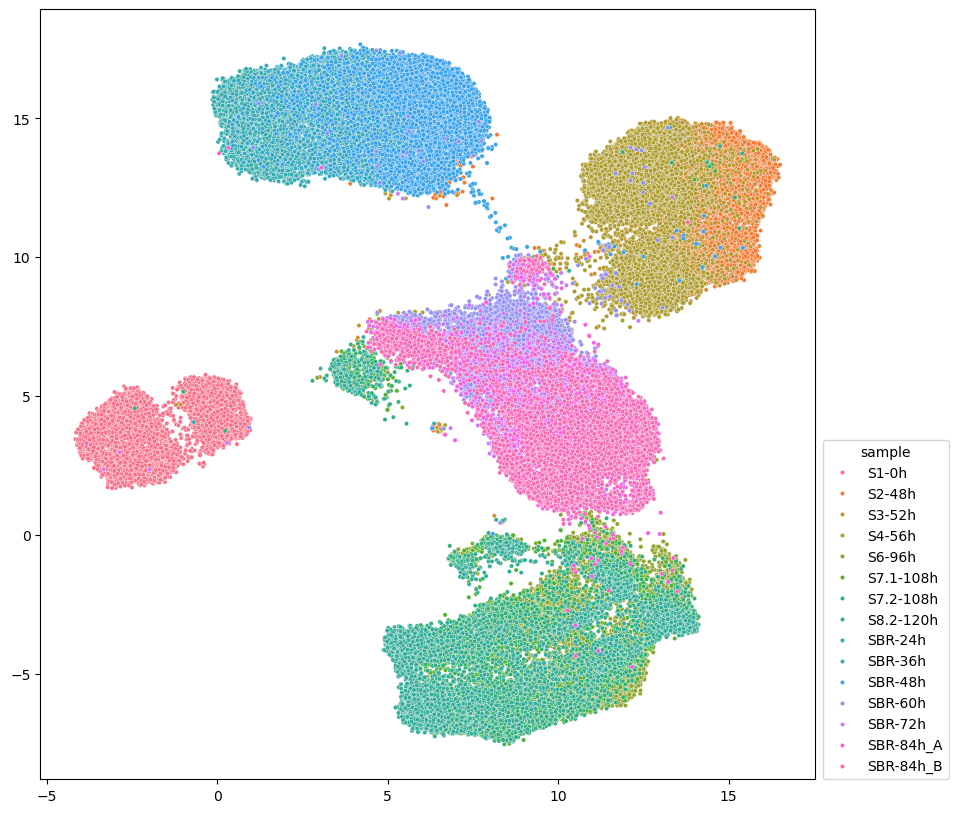

In [100]:
for hue in ["sample"]:            
    fig,ax = plt.subplots(figsize=[10,10])
    sns.scatterplot(x=adata.obsm["X_umap_pca"][:,0],y=adata.obsm["X_umap_pca"][:,1],hue=adata.obs[hue],s=10)
    ax.legend(loc=(1.01,0),title=hue)
    fig.savefig(f"results/{analysis_name}/dr_umap_pca.{save_format}")

## 3. Batch correction: scvi

In [52]:
adata_ = adata[:,adata.var["highly_variable"].values]
adata_ = adata_.copy()

In [53]:
scvi.model.SCVI.setup_anndata(adata_,batch_key="sample")
vae = scvi.model.SCVI(adata_)
vae.train(early_stopping=True,check_val_every_n_epoch=1,early_stopping_monitor='elbo_validation')

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 115/115: 100%|██████████| 115/115 [4:37:15<00:00, 121.51s/it, v_num=1, train_loss_step=726, train_loss_epoch=721]   

`Trainer.fit` stopped: `max_epochs=115` reached.


Epoch 115/115: 100%|██████████| 115/115 [4:37:15<00:00, 144.66s/it, v_num=1, train_loss_step=726, train_loss_epoch=721]


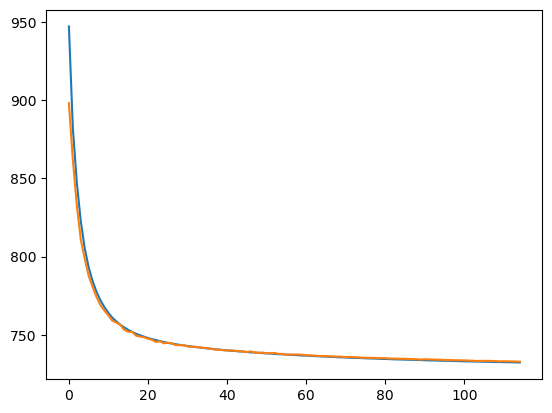

In [54]:
plt.plot(vae.history["elbo_train"].values)
plt.plot(vae.history["elbo_validation"].values)

In [55]:
adata.obsm["X_scvi"] = vae.get_latent_representation()

In [56]:
sp.pp.neighbors(adata, 
                metric=parameters["metric"], 
                use_rep="X_scvi",
                key_added="neighbors_scvi",
                n_neighbors=10,
)
sp.tl.umap(adata, neighbors_key="neighbors_scvi")
adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

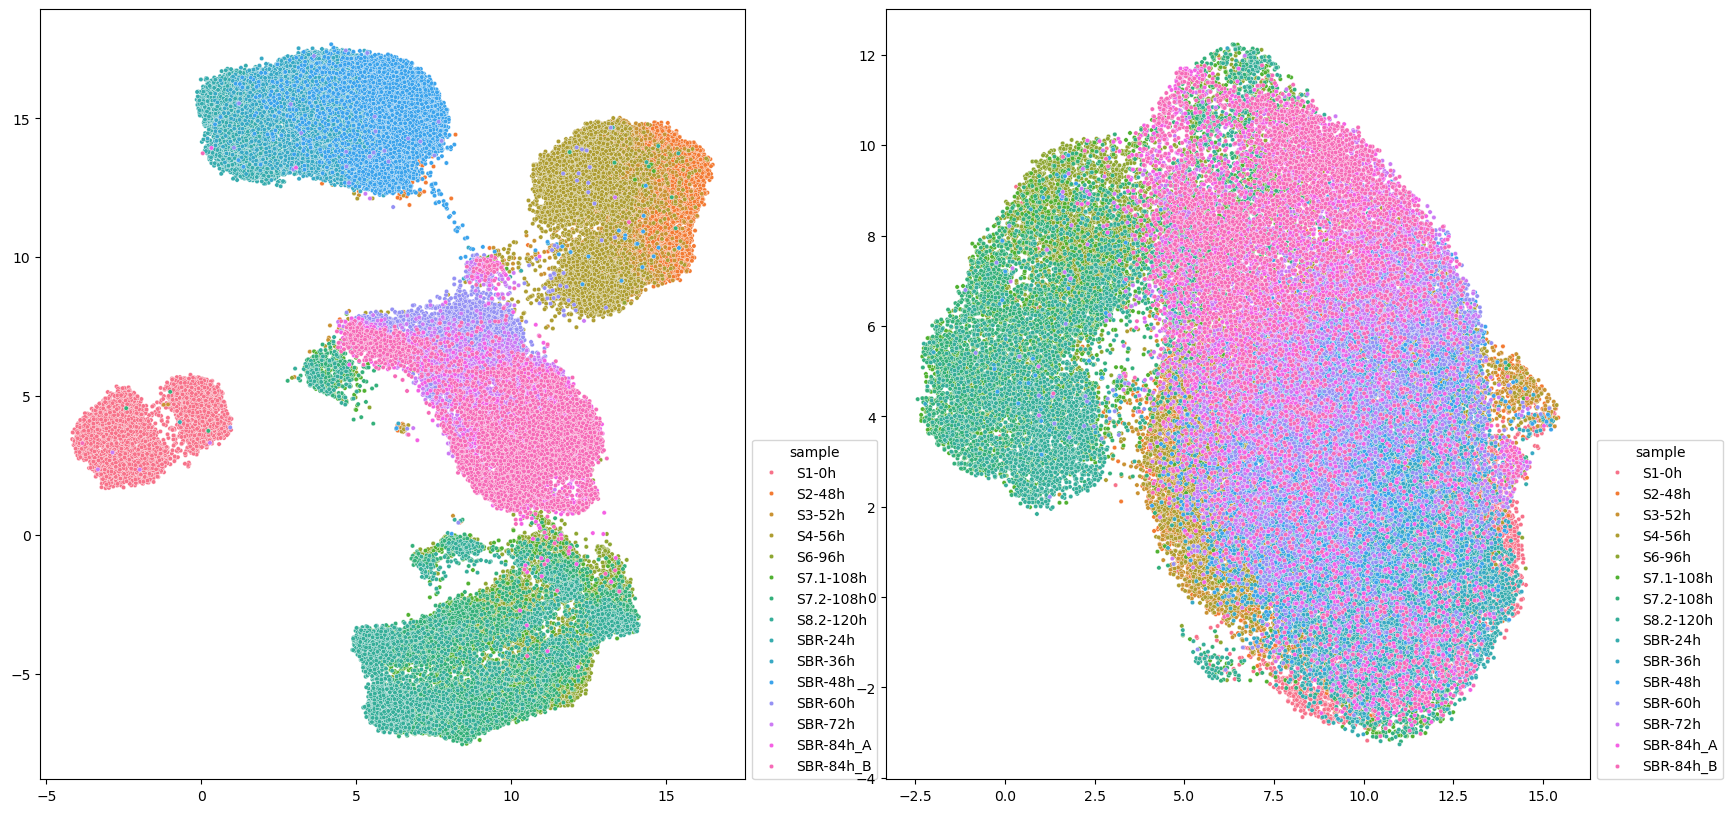

In [101]:
for hue in ["sample"]:            
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    order = np.argsort(adata.obs[hue])
    sns.scatterplot(x=adata.obsm["X_umap_pca"][order,0],y=adata.obsm["X_umap_pca"][order,1],hue=adata.obs[hue],s=10, ax=ax[0])
    ax[0].legend(loc=(1.01,0),title=hue)

    order = np.argsort(adata.obs[hue])
    sns.scatterplot(x=adata.obsm["X_umap_scvi"][order,0],y=adata.obsm["X_umap_scvi"][order,1],hue=adata.obs[hue][order],s=10, ax=ax[1])
    ax[1].legend(loc=(1.01,0),title=hue)
    fig.savefig(f"results/{analysis_name}/dr_umap_pca_vs_scvi.{save_format}")    

## Save

In [58]:
adata.write(f"{data_folder}/{analysis_name}_processed.h5ad")

## Load file

In [59]:
# read file
adata=sp.read_h5ad(f"{data_folder}/{analysis_name}_processed.h5ad")

# 4. Marker genes 

In [60]:
genes = pd.read_csv('markers.txt', header=None).iloc[:,0].values

In [103]:
for gene in genes:
    for t in adata.obs["stage"].unique():
        fig,ax = plt.subplots(1,1,figsize=[2.32,2.32])

        # gene expression
        hue = adata[adata.obs.stage==t][:,gene].X.toarray()[:,0]
        sns.scatterplot(x=adata.obsm["X_umap_scvi"][:,0],y=adata.obsm["X_umap_scvi"][:,1],color="lightgray",s=5,ax=ax)
        sns.scatterplot(x=adata[adata.obs.stage==t].obsm["X_umap_scvi"][:,0],y=adata[adata.obs.stage==t].obsm["X_umap_scvi"][:,1],hue=hue,s=5,ax=ax)

        ax.set_title(gene, fontsize=7)
        ax.legend(title=t, title_fontsize=5, prop={'size':5}, loc=(1.01,0.005))

        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        
        os.makedirs(f'results/{analysis_name}/umap_genes/', exist_ok=True)
        fig.savefig(f"results/{analysis_name}/umap_genes/umap_{gene}_{t}.{save_format}", dpi=300, bbox_inches='tight')    
        plt.close()

# 5. Clustering

In [62]:
sp.pp.neighbors(adata, use_rep="X_scvi")

In [94]:
sp.tl.leiden(adata, resolution=parameters['resolution'])

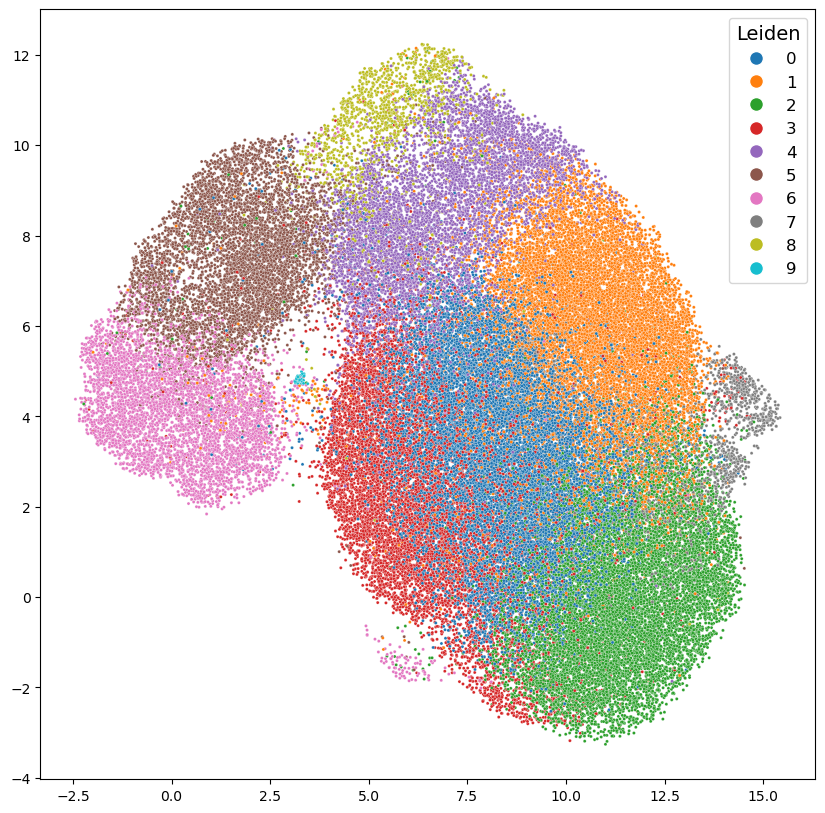

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# Create the scatterplot
scatter = sns.scatterplot(
    x=adata.obsm["X_umap_scvi"][:, 0],
    y=adata.obsm["X_umap_scvi"][:, 1],
    hue=adata.obs["leiden"],
    s=5,
    ax=ax,
    legend=False  # Disable default legend
)

# Manually rebuild legend with bigger dots
unique_clusters = adata.obs["leiden"].unique().sort_values()
palette = dict(zip(unique_clusters, sns.color_palette(n_colors=len(unique_clusters))))
handles = [Line2D([0], [0], marker='o', color='w', label=cl,
                  markerfacecolor=palette[cl], markersize=10) for cl in unique_clusters]

ax.legend(handles=handles, title="Leiden", loc="best", fontsize=12, title_fontsize=14)

fig.savefig(f"results/{analysis_name}/umap_clusters.{save_format}", dpi=300, bbox_inches='tight')

# 2. Correlation between genes

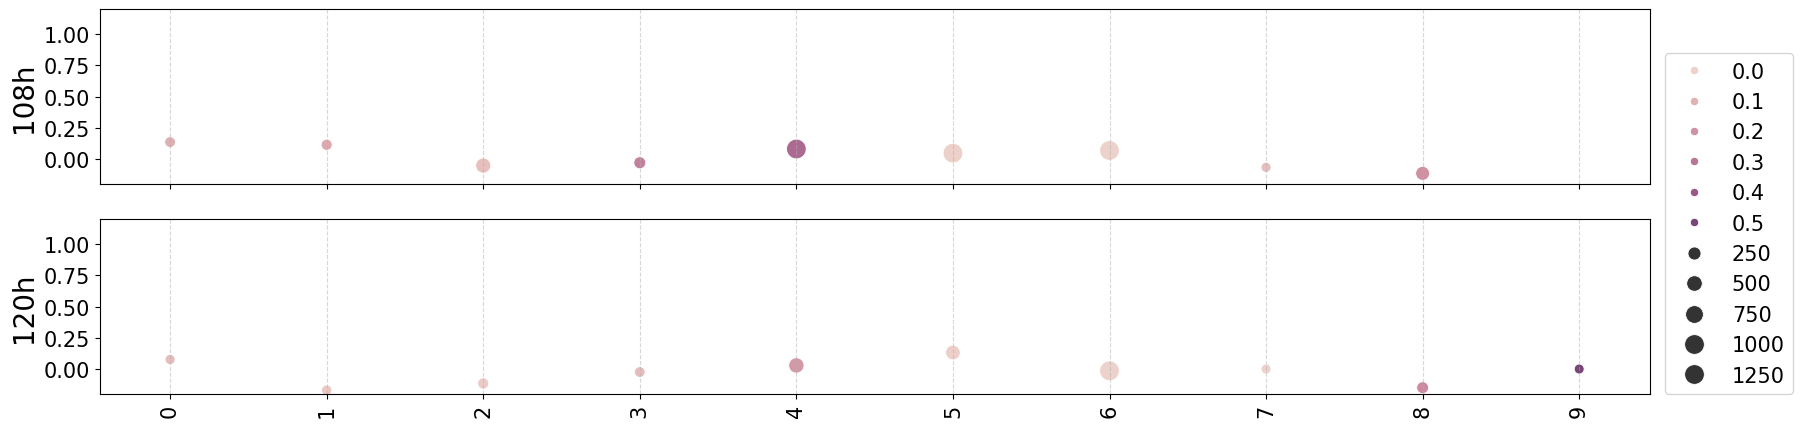

In [ ]:
gene1_name = "T"
gene2_name = "Cdh1"

stages = ["108h", "120h"]

fig, ax = plt.subplots(len(stages), 1, figsize=[20, 2.5 * len(stages)], sharex=True)
for i,t in enumerate(stages):

    cs = []
    ss = []
    cols = []
    for celltype in adata.obs["leiden"].unique():
        gene1 = adata[(adata.obs.stage==t).values, gene1_name].layers["counts"].toarray()[:,0]
        gene2 = adata[(adata.obs.stage==t).values, gene2_name].layers["counts"].toarray()[:,0]
        ann = adata[(adata.obs.stage==t).values,:].obs["leiden"].values == celltype
        c = np.corrcoef(gene1[ann],gene2[ann])[0,1]
        c = np.nan_to_num(c, nan=0)
        s = sum(ann)
        # print(t, c, s, sum(gene1[ann] > 0), sum(gene2[ann] > 0))
        col = np.nan_to_num(sum((gene1[ann]*gene2[ann]) > 0) / sum(ann), nan=0)
        cs.append(c)
        ss.append(s)
        cols.append(col)

    sns.scatterplot(x=adata.obs["leiden"].unique(), y=cs, hue=cols, size=ss, hue_norm=(0,0.7), size_norm=(0,1000), sizes=(50,200), ax=ax[i]) 
    ax[i].set_ylabel(t, fontsize=20)
    ax[i].set_ylim(-0.2,1.2)
    ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=15)
    ax[i].grid(axis='x', linestyle='--', alpha=0.5, zorder=-1)
    if i != len(stages)-1:
        try:
            ax[i].get_legend().remove()
        except:
            None
    else:
        ax[i].legend(loc=(1.01,0), fontsize=15)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, fontsize=15)

fig.savefig(f"results/{analysis_name}/correlation_plot_{gene1_name}_{gene2_name}.{save_format}", dpi=300, bbox_inches='tight')    
